In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = Path('/kaggle/input/amazon-stock-data')
data = pd.read_csv(path / 'AMZN.csv')

In [3]:
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])
#plt.plot(data['Date'], data['Close'])

/tmp/ipykernel_20/3175323656.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'Date'] = pd.to_datetime(data['Date'])


In [4]:
train_test_index = int(0.8 * len(data))
train_data = data.iloc[:train_test_index]
test_data = data.iloc[train_test_index:]

# Baseline - MLP
Ocuparemos 10 rezagos.

In [5]:
num_rezagos = 10 

for i in range(1, num_rezagos + 1):
    train_data[f'Rezago_{i}'] = train_data['Close'].shift(i)
    test_data[f'Rezago_{i}'] = test_data['Close'].shift(i)

train_data.dropna(inplace = True)
test_data.dropna(inplace = True)

/tmp/ipykernel_20/3349062530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f'Rezago_{i}'] = train_data['Close'].shift(i)
/tmp/ipykernel_20/3349062530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'Rezago_{i}'] = test_data['Close'].shift(i)
/tmp/ipykernel_20/3349062530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [6]:
columns = [f'Rezago_{i}' for i in range(10,0,-1)]
columns.append('Close')

train_data = train_data[columns]
test_data = test_data[columns]

X_train, y_train = train_data.values[:, :-1].astype(np.float32), train_data.values[:, -1:].astype(np.float32)
X_test, y_test = test_data.values[:, :-1].astype(np.float32), test_data.values[:, -1:].astype(np.float32)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4995, 10), (4995, 1), (1242, 10), (1242, 1))

In [8]:
windows = train_data[-40:]
columns = [f'Rezago_{i}' for i in range(10,0,-1)]
columns.append('Close')
windows = windows[columns]

In [9]:
windows = windows.reset_index(drop = True)

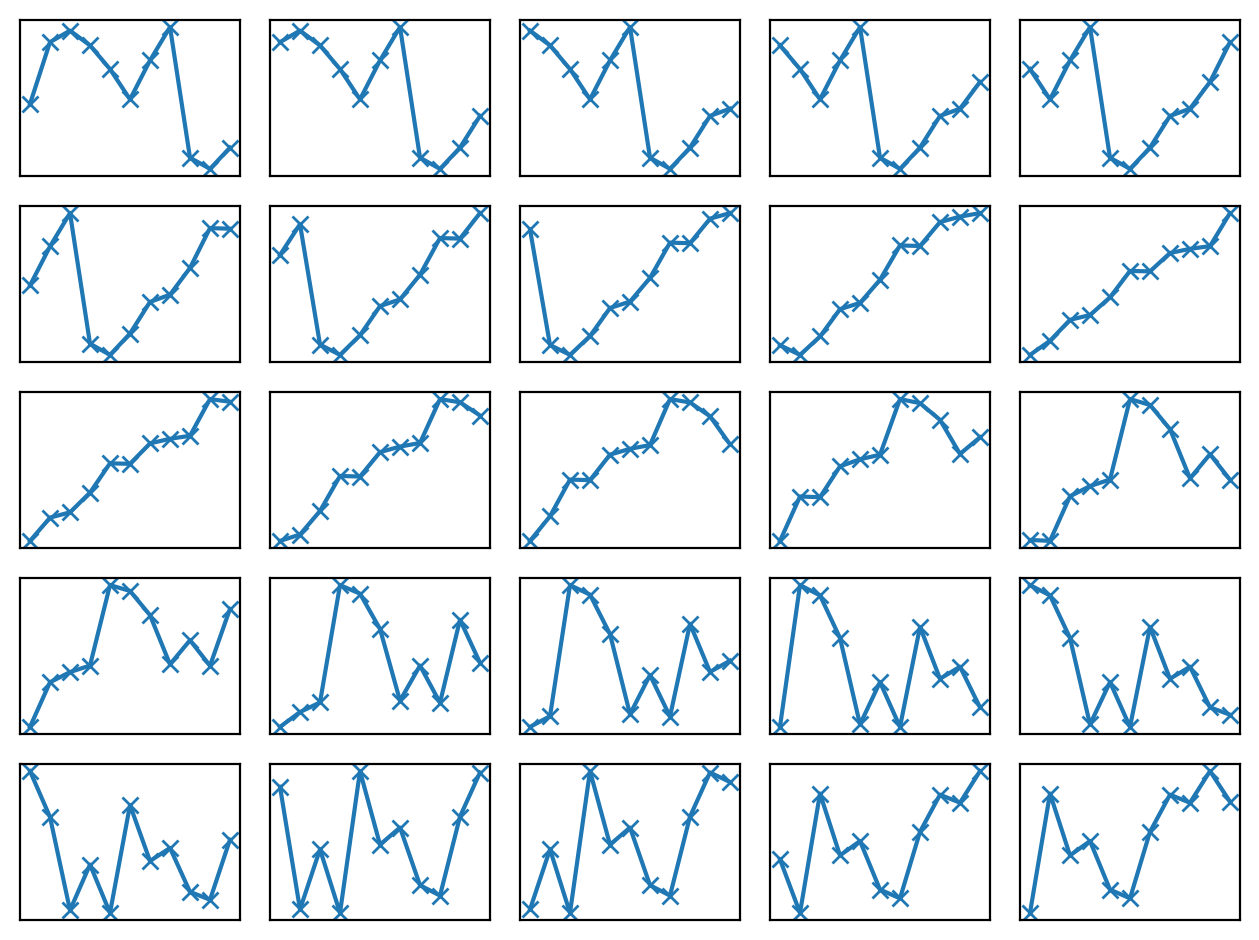

In [10]:
fig = plt.figure(dpi=200)
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.plot(range(0, len(windows.loc[i,:])), windows.loc[i,:], '-x') # Cada valor de cierre con sus rezagos
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y = None, train = True):
        self.X = X
        self.y = y
        self.train = train
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])
        

dataloader = {
    'train': DataLoader(TimeSeriesDataset(X_train, y_train), shuffle = True, batch_size = 64),
    'test': DataLoader(TimeSeriesDataset(X_test, y_test), shuffle = False, batch_size = 64)
}

In [12]:
x, y = next(iter(dataloader['train']))
x.shape, y.shape, x.dtype

(torch.Size([64, 10]), torch.Size([64, 1]), torch.float32)

In [13]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
mlp = MLP(10, 100, 1)
mlp

MLP(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
from tqdm import tqdm

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['test']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f" Epoch {epoch}/{epochs} loss {np.mean(train_loss):.8f} val_loss {np.mean(eval_loss):.8f}")

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
fit(mlp, dataloader, epochs=100)

 Epoch 100/100 loss 27.74994523 val_loss 6181.91258850: 100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


In [17]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X, _ = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [18]:
y_pred = predict(mlp, dataloader['test'])

y_pred

tensor([[ 878.0164],
        [ 879.7950],
        [ 877.6978],
        ...,
        [3157.5403],
        [3189.8069],
        [3195.8044]])

[]

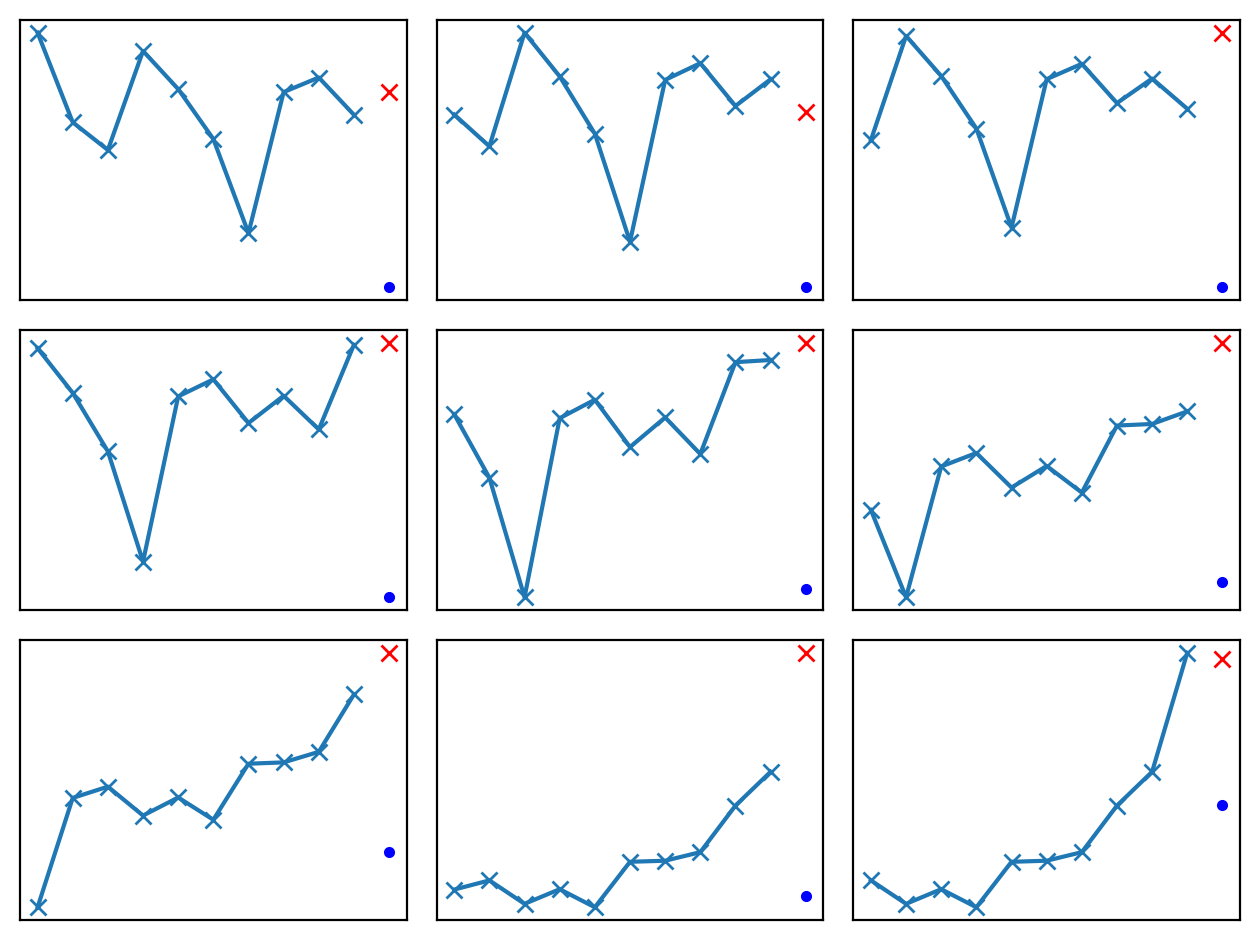

In [19]:
fig = plt.figure(dpi = 200)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.plot(range(0, len(X_test[i])), X_test[i], '-x')
    ax.plot(range(len(X_test[i]), len(X_test[i])+1), y_test[i], '-rx')
    ax.plot(range(len(X_test[i]), len(X_test[i])+1), y_pred[i], '-b.') # Punto azul es la predicción
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.plot()

# RNN

In [20]:
# Debemos agregar una tercera dimensión para cada t
# En este caso la tercera dimensión es 1
# La primera dimensión es el batch, instantes (10 pasos), caracteristicas
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y = None, train = True):
        self.X = X
        self.y = y
        self.train = train
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        if self.train:
            return torch.unsqueeze(torch.from_numpy(self.X[ix]), 1), torch.from_numpy(self.y[ix])
        return torch.unsqueeze(torch.from_numpy(self.X[ix]),1)

In [21]:
dataloader = {
    'train': DataLoader(TimeSeriesDataset(X_train, y_train), shuffle = True, batch_size = 64),
    'test': DataLoader(TimeSeriesDataset(X_test, y_test), shuffle = False, batch_size = 64)
}

In [22]:
x, y = next(iter(dataloader['train']))

In [23]:
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(20, 1)
    def forward(self, x):
        x, h = self.rnn(x)
        y = self.fc(x[:, -1])
        return y

rnn = RNN()
rnn

RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [24]:
fit(rnn, dataloader, epochs=1000)

 Epoch 1000/1000 loss 46.29563350 val_loss 2594811.74965820: 100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


In [25]:
y_pred = predict(rnn, dataloader['test'])
y_pred

tensor([[855.6865],
        [855.9188],
        [855.7678],
        ...,
        [860.5717],
        [860.5716],
        [860.5716]])

[]

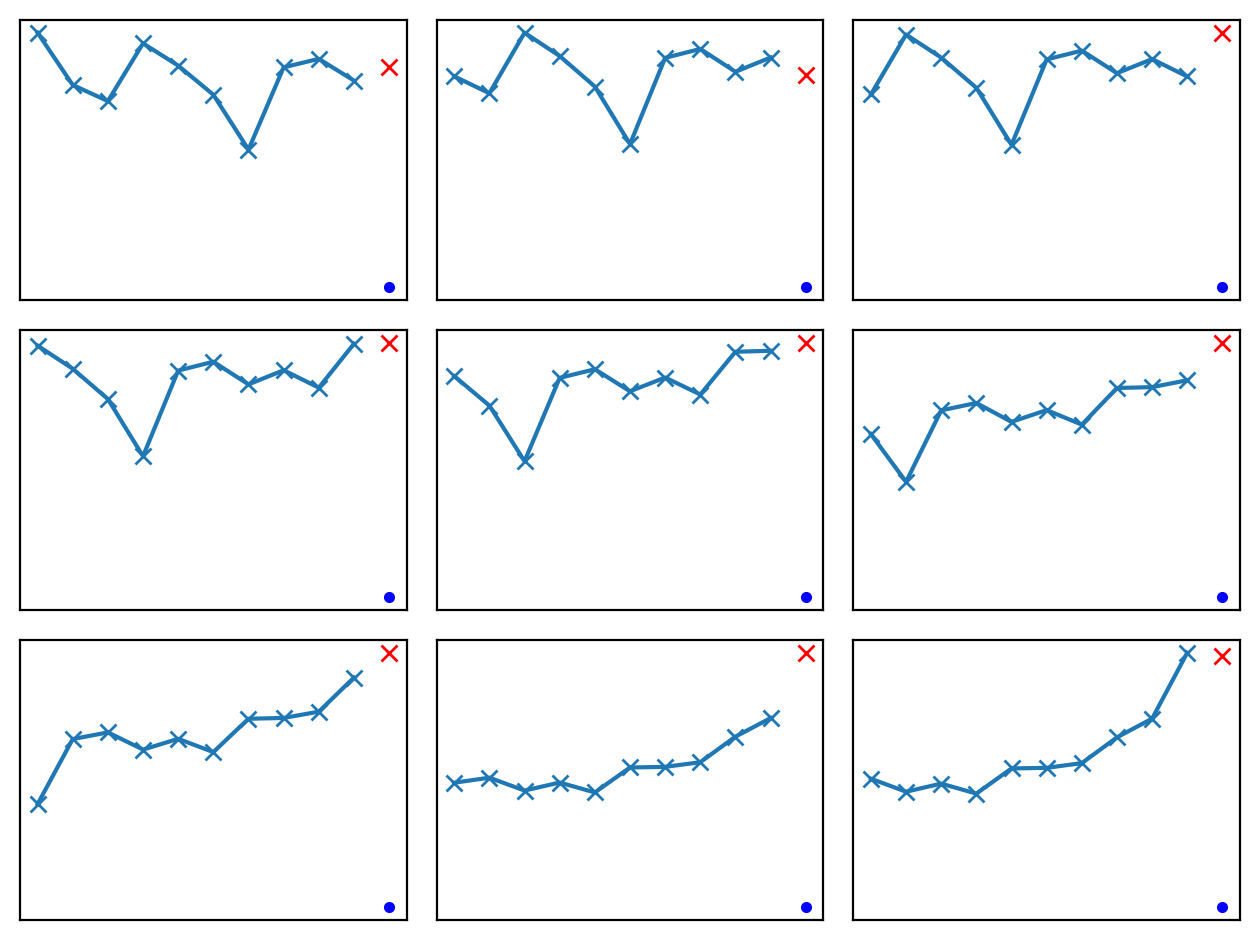

In [26]:
fig = plt.figure(dpi = 200)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.plot(range(0, len(X_test[i])), X_test[i], '-x')
    ax.plot(range(len(X_test[i]), len(X_test[i])+1), y_test[i], '-rx')
    ax.plot(range(len(X_test[i]), len(X_test[i])+1), y_pred[i], '-b.') # Punto azul es la predicción
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.plot()